In [1]:
# --- 0. 安装必要的库 ---
# 在Kaggle环境中需要先安装 sentence-transformers
# （确保在 Notebook 的 Settings -> Internet 中打开网络）
!pip install -q sentence-transformers transformers

# --- 1. 导入库 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import sys
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    print("错误：无法导入 SentenceTransformer。请先成功安装后再运行。")
    sys.exit()

# --- 2. 设置字体和文件路径 (按你的要求) ---
font_path_chinese = "/kaggle/input/nsfc2025-management/simkai.ttf"
font_path_english = "/kaggle/input/nsfc2025-management/times.ttf"
data_file = "/kaggle/input/nsfc2025-management/nsfc-2025-management-title-fenci.csv"

# 字体检查与注册（中文/英文）
if os.path.exists(font_path_chinese):
    ch_font = fm.FontProperties(fname=font_path_chinese)
    fm.fontManager.addfont(font_path_chinese)
else:
    print(f"警告: 字体文件 '{font_path_chinese}' 未找到，中文显示可能不完整。")
    ch_font = fm.FontProperties()

if os.path.exists(font_path_english):
    en_font = fm.FontProperties(fname=font_path_english)
    fm.fontManager.addfont(font_path_english)
else:
    print(f"警告: 字体文件 '{font_path_english}' 未找到，英文字体将使用默认。")
    en_font = fm.FontProperties()

# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False

# --- 3. 加载与校验数据（仅两列：项目名称、项目名称分词） ---
print(f"正在从 '{data_file}' 加载数据...")
try:
    df = pd.read_csv(data_file, dtype=str, encoding="utf-8")
except FileNotFoundError:
    print(f"错误: 数据文件 '{data_file}' 未找到。")
    sys.exit()
except Exception as e:
    print(f"读取 CSV 文件时出错: {e}")
    sys.exit()

# 去除列名两端空格，兼容“项目名称分词 ”等情况
df.columns = [str(c).strip() for c in df.columns]

required_cols = {"项目名称", "项目名称分词"}
if not required_cols.issubset(set(df.columns)):
    print(f"错误：数据中缺少必需列。需要列：{required_cols}，当前列：{list(df.columns)}")
    sys.exit()

# 仅保留这两列（防御性）
df = df.loc[:, ["项目名称", "项目名称分词"]].copy()

# 获取标题列表（用于嵌入/聚类）；如需改用“项目名称分词”也可将下一行替换为 df["项目名称分词"]
titles = df["项目名称"].dropna().astype(str).tolist()
if not titles:
    print("错误：未找到有效的项目名称。")
    sys.exit()

print(f"已加载 {len(titles)} 条项目标题。示例前3条：")
for t in titles[:3]:
    print(" -", t)

# --- 4. 加载嵌入模型并生成编码 ---
model_name = "jinaai/jina-embeddings-v2-base-zh"
print(f"正在从 Hugging Face 加载模型：{model_name} ...")
try:
    model = SentenceTransformer(model_name, trust_remote_code=True)
    print("模型加载成功。")
except Exception as e:
    print(f"加载模型时出错: {e}")
    print("请确认网络已开启。")
    sys.exit()

print(f"正在为 {len(titles)} 个标题生成编码（可能需要一些时间）...")
embeddings = model.encode(titles, show_progress_bar=True)
print(f"编码完成。shape = {embeddings.shape}")

# --- 5. K-means 聚类与评估 ---
K_range = range(2, 16)  # K ∈ [2, 15]
silhouette_scores = []
ch_scores = []
db_scores_inv = []

print("开始 K-means 聚类与评估循环 (K=2 到 15)...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)

    # a. Silhouette 系数（越高越好）
    sil = silhouette_score(embeddings, labels)
    silhouette_scores.append(sil)

    # b. Calinski–Harabasz 指数（越高越好）
    ch = calinski_harabasz_score(embeddings, labels)
    ch_scores.append(ch)

    # c. Davies–Bouldin 指数（越低越好），这里存 1-DB 使“越高越好”
    db = davies_bouldin_score(embeddings, labels)
    db_scores_inv.append(1 - db)

    print(f"  K={k}: Silhouette={sil:.3f}, CH={ch:.0f}, 1-DB={1-db:.3f}")

print("聚类评估完成。")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 15.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.7 MB/s eta 0:00:00:00:0100:01
ERROR: pip's depend

2025-10-23 07:17:52.498088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761203872.765668      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761203872.840194      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


正在从 '/kaggle/input/nsfc2025-management/nsfc-2025-management-title-fenci.csv' 加载数据...
已加载 927 条项目标题。示例前3条：
 - 宏观金融
 - 金融中介
 - 创造力与创新
正在从 Hugging Face 加载模型：jinaai/jina-embeddings-v2-base-zh ...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_bert.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True

modeling_bert.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- modeling_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/322M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

模型加载成功。
正在为 927 个标题生成编码（可能需要一些时间）...


Batches:   0%|          | 0/29 [00:00<?, ?it/s]

编码完成。shape = (927, 768)
开始 K-means 聚类与评估循环 (K=2 到 15)...
  K=2: Silhouette=0.030, CH=30, 1-DB=-4.548
  K=3: Silhouette=0.027, CH=25, 1-DB=-4.155
  K=4: Silhouette=0.026, CH=23, 1-DB=-3.795
  K=5: Silhouette=0.029, CH=21, 1-DB=-3.604
  K=6: Silhouette=0.028, CH=20, 1-DB=-3.320
  K=7: Silhouette=0.029, CH=18, 1-DB=-3.200
  K=8: Silhouette=0.029, CH=17, 1-DB=-3.181
  K=9: Silhouette=0.030, CH=16, 1-DB=-3.111
  K=10: Silhouette=0.029, CH=16, 1-DB=-3.051
  K=11: Silhouette=0.026, CH=14, 1-DB=-3.012
  K=12: Silhouette=0.033, CH=14, 1-DB=-2.855
  K=13: Silhouette=0.032, CH=14, 1-DB=-2.834
  K=14: Silhouette=0.030, CH=13, 1-DB=-2.932
  K=15: Silhouette=0.028, CH=12, 1-DB=-2.829
聚类评估完成。


正在生成评估图表...
图表已成功保存为: management_clustering_metrics.png (位于 /kaggle/working/ 目录)
正在显示图表: 聚类评估


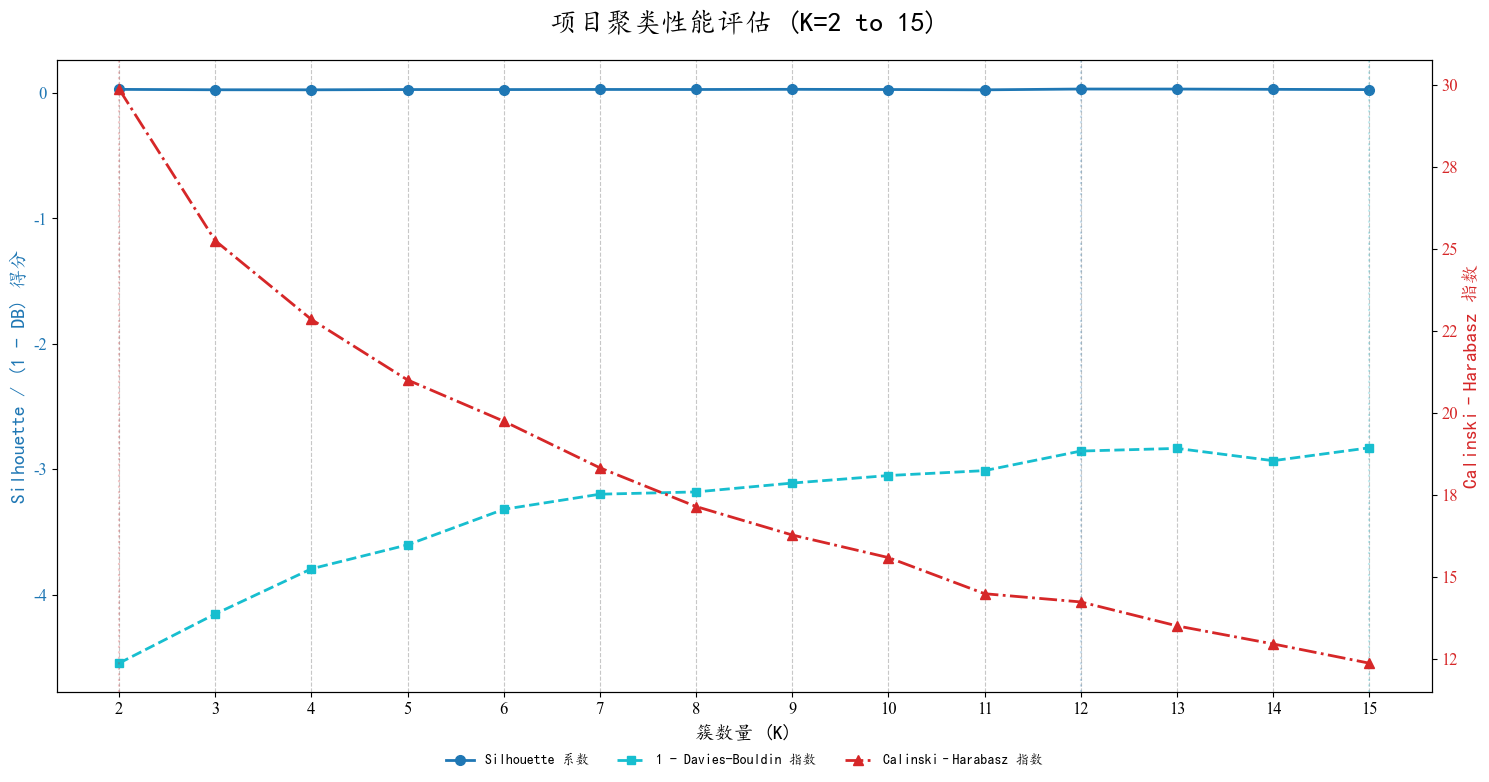

所有任务完成。


In [2]:
from matplotlib.ticker import StrMethodFormatter

# --- 6. 绘制评估指标图表（微调版） ---
print("正在生成评估图表...")
fig, ax1 = plt.subplots(figsize=(15, 8))

# 标题（通用，不依赖 target_discipline）
plt.title('项目聚类性能评估 (K=2 to 15)', fontproperties=ch_font, fontsize=20, pad=20)

# X轴
K_list = list(K_range)  # 确保是 list，便于索引与标注
ax1.set_xlabel('簇数量 (K)', fontproperties=ch_font, fontsize=14)
ax1.set_xticks(K_list)  # 确保X轴刻度为整数
plt.setp(ax1.get_xticklabels(), fontproperties=en_font, fontsize=12)

# Y轴1：Silhouette & 1-DB
color1 = 'tab:blue'
ax1.set_ylabel('Silhouette / (1 - DB) 得分', fontproperties=ch_font, fontsize=14, color=color1)

# 注意：ASCII '-'，避免 U+2212
line1 = ax1.plot(K_list, silhouette_scores, marker='o', linestyle='-', color='tab:blue',
                 linewidth=2, markersize=7, label='Silhouette 系数')
line2 = ax1.plot(K_list, db_scores_inv,  marker='s', linestyle='--', color='tab:cyan',
                 linewidth=2, markersize=6, label='1 - Davies-Bouldin 指数')

ax1.tick_params(axis='y', labelcolor=color1)
plt.setp(ax1.get_yticklabels(), fontproperties=en_font, fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7, axis='x')

# Y轴2：CH 指数（右轴）
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Calinski–Harabasz 指数', fontproperties=ch_font, fontsize=14, color=color2)
line3 = ax2.plot(K_list, ch_scores, marker='^', linestyle='-.', color=color2,
                 linewidth=2, markersize=7, label='Calinski–Harabasz 指数')
ax2.tick_params(axis='y', labelcolor=color2)
plt.setp(ax2.get_yticklabels(), fontproperties=en_font, fontsize=12)
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))  # 千分位

# --- 标注三项指标的“最佳 K” ---
best_k_sil = K_list[int(np.argmax(silhouette_scores))]
best_k_db  = K_list[int(np.argmax(db_scores_inv))]
best_k_ch  = K_list[int(np.argmax(ch_scores))]

# 垂直虚线（用不同样式区分）
for k, ls, c in [(best_k_sil, ':', 'tab:blue'),
                 (best_k_db,  ':', 'tab:cyan'),
                 (best_k_ch,  ':', 'tab:red')]:
    ax1.axvline(k, linestyle=ls, color=c, alpha=0.25)



# --- 图例放在图下方 ---
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]

fig.subplots_adjust(bottom=0.22)  # 为底部图例预留空间
legend = fig.legend(
    lines, labels,
    loc='lower center',
    ncol=3,
    frameon=False,
    prop=ch_font,
    bbox_to_anchor=(0.5, 0.02)
)

fig.tight_layout(rect=[0, 0.05, 1, 1])  # 与底部图例协调（保留 5% 底边）

# --- 7. 显示和保存图表 ---
output_filename = 'management_clustering_metrics.png'
try:
    fig.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"图表已成功保存为: {output_filename} (位于 /kaggle/working/ 目录)")
except Exception as e:
    print(f"保存图表 '{output_filename}' 时出错: {e}")

try:
    print("正在显示图表: 聚类评估")
    plt.show()
except Exception as e:
    print(f"显示图表时出错: {e}")

plt.close(fig)
print("所有任务完成。")


In [3]:
print("K = 7")

K = 7
